<a href="https://colab.research.google.com/github/manmeet3/Deep_Learning2/blob/master/GradientBoostMachines/Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The intuition behind gradient boosting is to leverate the pattern in residuals and strengthen a weak prediction model. 

In [69]:
%matplotlib inline

import numpy as np
import pandas as pd
from fastai.imports import *
from IPython.display import display
from sklearn import metrics

In [70]:
def std_agg(cnt, s1, s2):
  return math.sqrt((s2/cnt) - (s1/cnt)**2)

# TODO: Add comments

In [71]:
class DecisionTree():
  def __init__(self, x, y, idxs = None, min_leaf=2):
    if idxs is None:
      idxs = np.arange(len(y))
    self.x, self.y, self.idxs, self.min_leaf = x, y, idxs, min_leaf
    self.n, self.c, = len(idxs), x.shape[1]
    self.val = np.mean(y[idxs])
    self.score = float('inf')
    self.find_varsplit()

  def find_varsplit(self):
    for i in range(self.c):
      self.find_better_split(i)
    if self.score == float('inf'):
      return
    x = self.split_col
    left_subtree = np.nonzero(x <= self.split)[0]
    right_subtree = np.nonzero(x > self.split)[0]
    self.left_subtree = DecisionTree(self.x, self.y, self.idxs[left_subtree])
    self.right_subtree = DecisionTree(self.x, self.y, self.idxs[right_subtree])

  def find_better_split(self, var_idx):
    x, y = self.x.values[self.idxs, var_idx], self.y[self.idxs]
    sort_idx = np.argsort(x)
    sort_y, sort_x = y[sort_idx], x[sort_idx]
    right_count, right_sum, right_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
    left_count, left_sum, left_sum2 = 0, 0.0, 0.0

    for i in range(0, self.n - self.min_leaf - 1):
      xi, yi = sort_x[i], sort_y[i]
      left_count += 1
      right_count -= 1
      left_sum += yi
      right_sum -= yi
      left_sum2 += yi**2
      right_sum2 -= yi**2
      if i<self.min_leaf or xi == sort_x[i+1]:
        continue
      
      left_std = std_agg(left_count, left_sum, left_sum2)
      right_std = std_agg(right_count, right_sum, right_sum2)
      curr_score = left_std * left_count + right_std * right_count
      if curr_score < self.score:
        self.var_idx, self.score, self.split = var_idx, curr_score, xi

  @property
  def split_name(self):
    return self.x.columns[self.var_idx]

  @property
  def split_col(self):
    return self.x.values[self.idxs, self.var_idx]

  @property
  def is_left(self):
    return self.score == float('inf')

  def __repr__(self):
    s = f'n: {self.n}; val:{self.val}'
    if not self.is_leaf:
      s += f'; score:{self.score}; split:{self.split}; var{self.split_name}'
    return s

  def predict(self, x):
    return np.array([self.predict_row(xi) for xi in x])

  def predict_row(self, xi):
    if self.is_leaf: 
      return self.val
    t = self.left_subtree if xi[self.var_idx] <= self.split else self.right_subtree
    return t.predict_row(xi)

Create test data by sampling and concatentating a few normal distributions

In [72]:
x = np.arange(0, 50)
x = pd.DataFrame({'x': x})

In [73]:
y1 = np.random.uniform(10, 20, 10)
y2 = np.random.uniform(20, 30, 10)
y3 = np.random.uniform(5, 20, 10)
y4 = np.random.uniform(25, 32, 10)
y5 = np.random.uniform(15, 30, 10)

y = np.concatenate((y1, y2, y3, y4, y5))
y = y[:, None]

In [74]:
x.shape, y.shape

((50, 1), (50, 1))

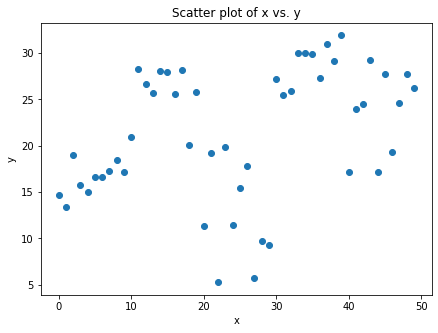

In [75]:
plt.figure(figsize=(7,5))
plt.plot(x,y, 'o')
plt.title("Scatter plot of x vs. y")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Gradient Boosting - Running Decision Trees in a loop

# TODO: Add comments

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

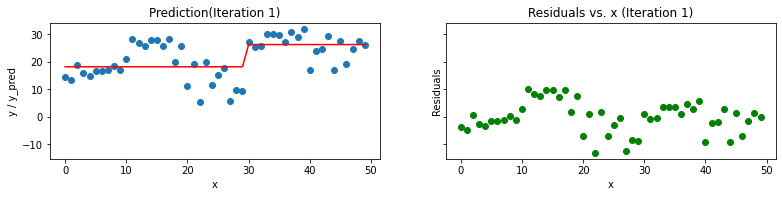

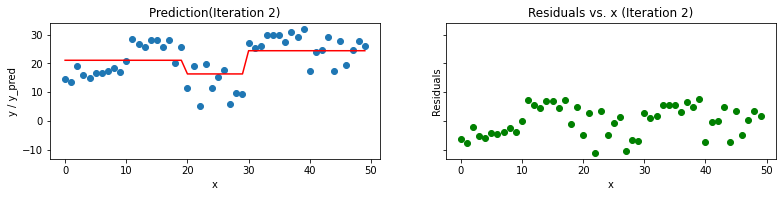

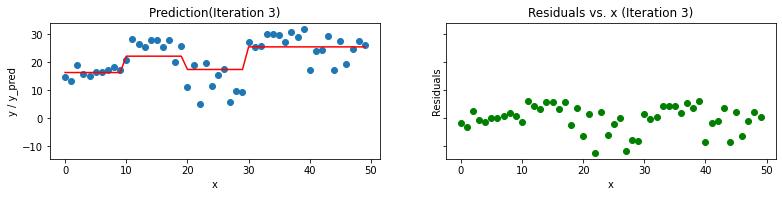

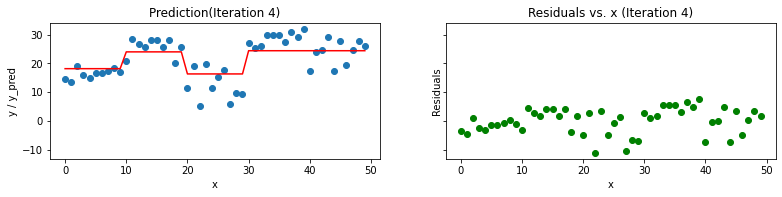

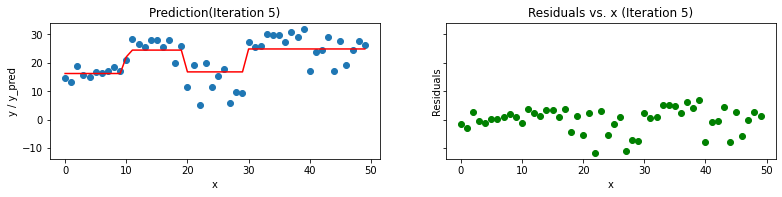

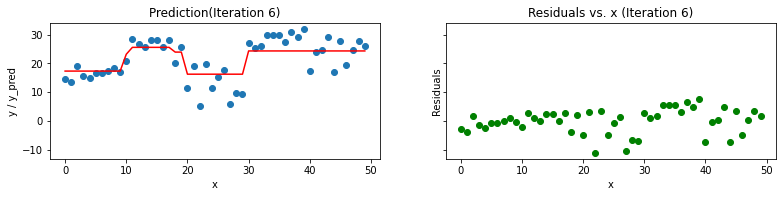

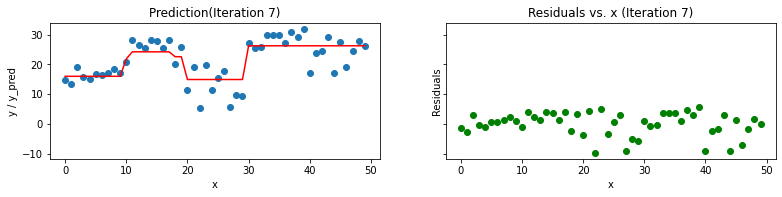

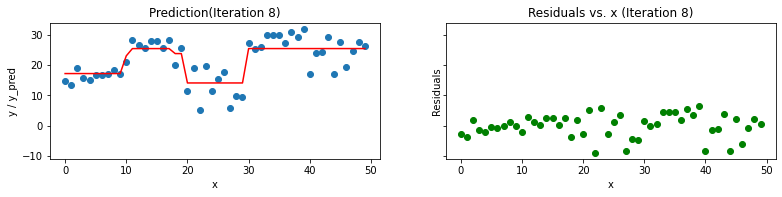

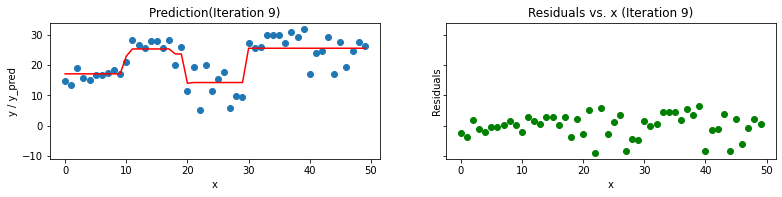

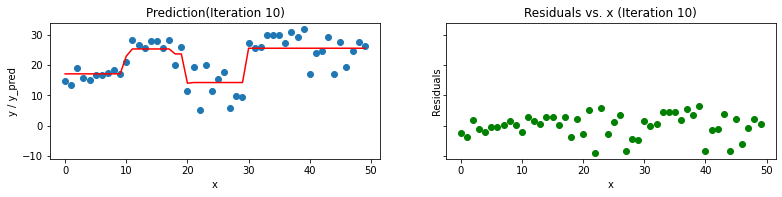

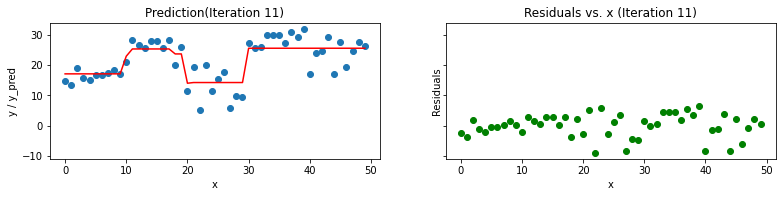

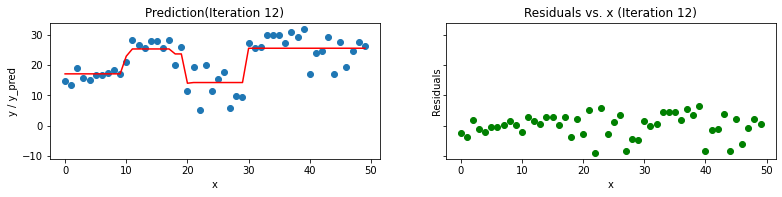

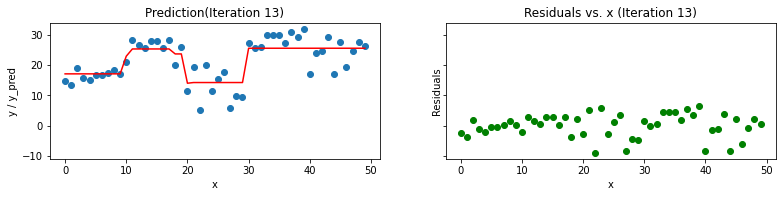

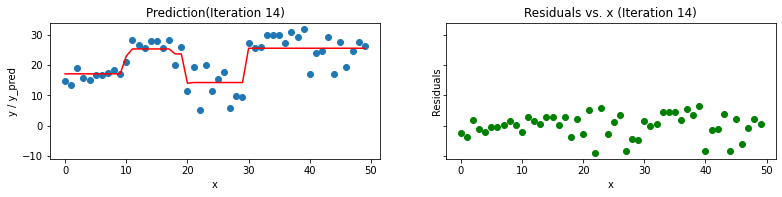

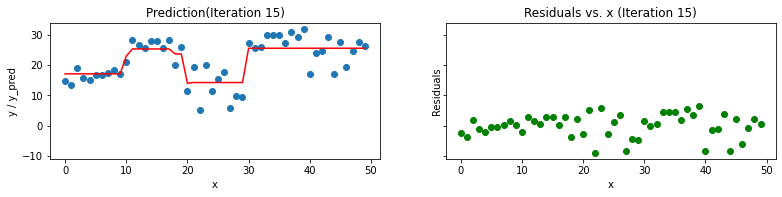

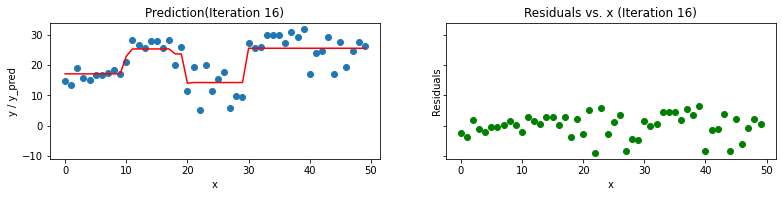

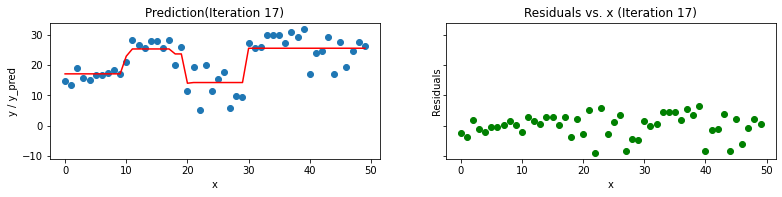

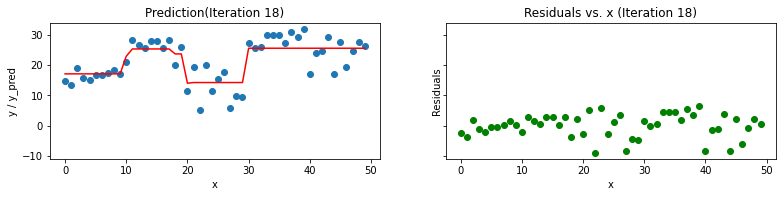

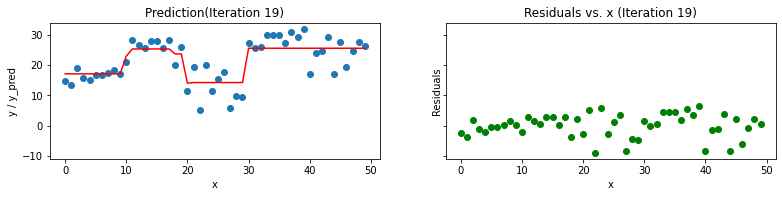

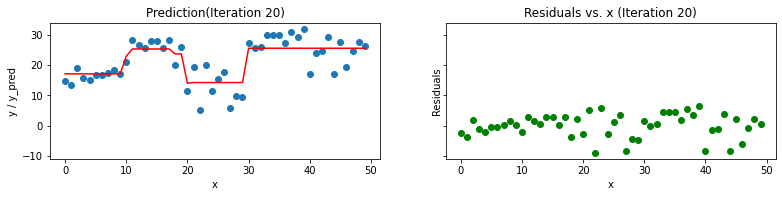

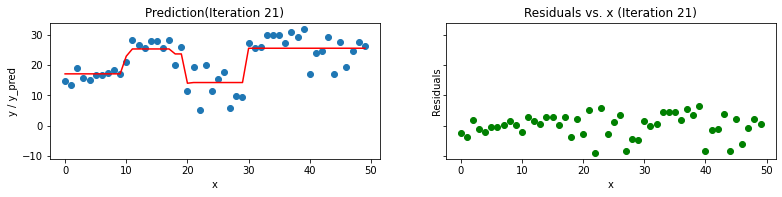

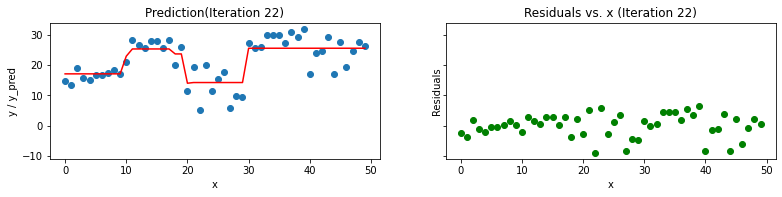

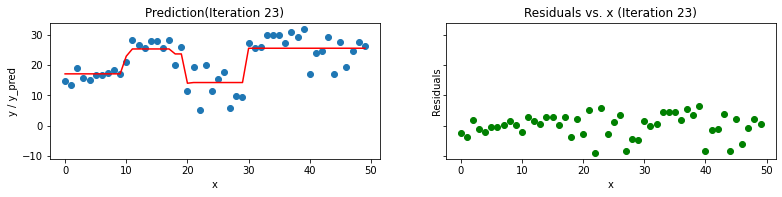

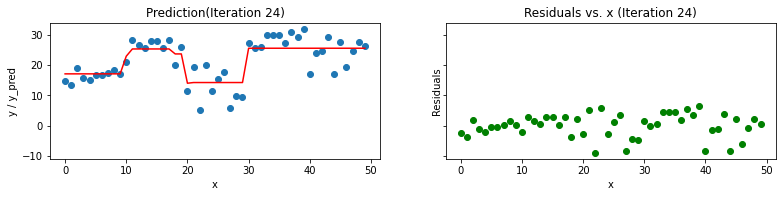

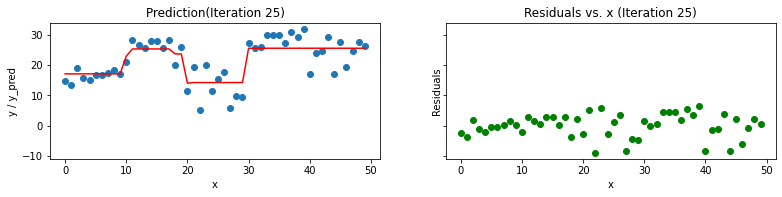

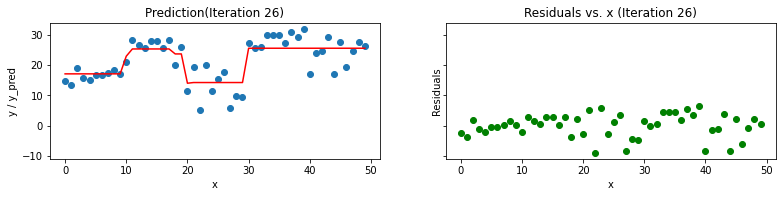

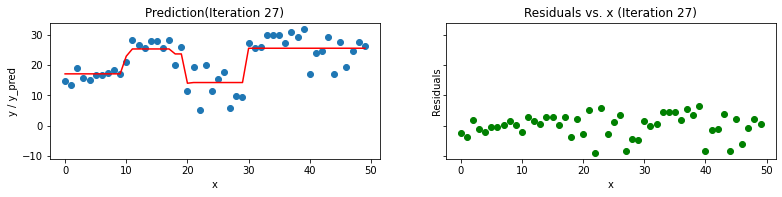

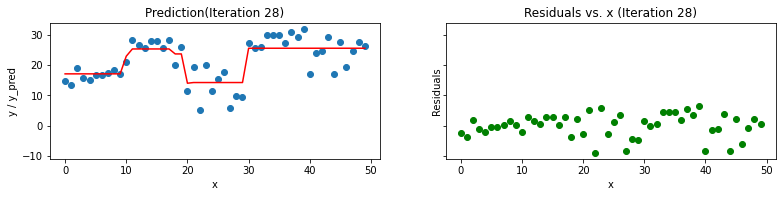

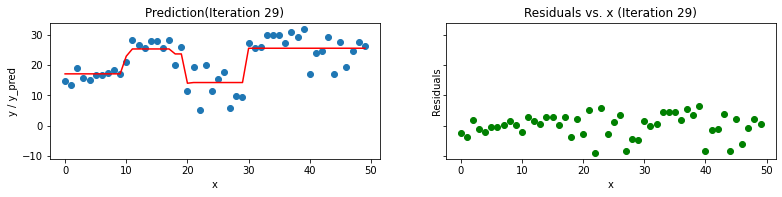

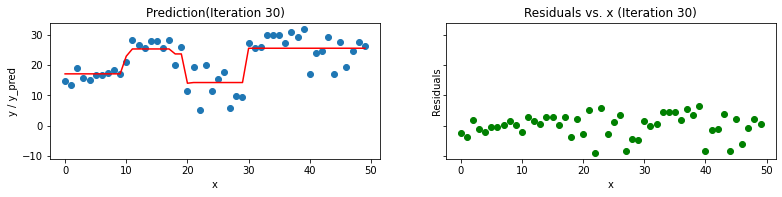

In [76]:
xi = x
yi = y
ei = 0
n = len(yi)
predf = 0

for i in range(30):
    tree = DecisionTree(xi, yi)
    tree.find_better_split(0)

    r = np.where(xi == tree.split)[0][0]

    left_idx = np.where(xi <= tree.split)[0]
    right_idx = np.where(xi > tree.split)[0]

    predi = np.zeros(n)
    np.put(predi, left_idx, np.repeat(np.mean(yi[left_idx]), r))
    np.put(predi, right_idx, np.repeat(np.mean(yi[right_idx]), n-r))

    predi = predi[:,None]
    predf = predf + predi

    ei = y - predf
    yi = ei

    xa = np.array(x.x)
    order = np.argsort(xa)
    xs = np.array(xa)[order]
    ys = np.array(predf)[order]

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13, 2.5))

    ax1.plot(x, y, 'o')
    ax1.plot(xs, ys, 'r')
    ax1.set_title(f'Prediction(Iteration {i+1})')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y / y_pred')

    ax2.plot(x, ei, 'go')
    ax2.set_title(f'Residuals vs. x (Iteration {i+1})')
    ax2.set_xlabel('x')
    ax2.set_ylabel('Residuals')

This colab takes inspiration from https://github.com/groverpr/Machine-Learning/blob/master/notebooks/01_Gradient_Boosting_Scratch.ipynb

This is an initial working replication. Will finetune in future